# **Predictive Modeling – Insurance Renewal Forecasting**

This project focuses on building predictive models to identify whether a client is likely to renew their insurance policy using anonymous customer data. The goal's to support decision-making through model comparison and selection.

**Key Objectives**

* Predict customer behavior regarding insurance policy renewal
* Compare model performance to select the best algorithm for deployment
* Apply hyperparameter tuning for improved accuracy and reliability

**Approach & Techniques**

* Data preprocessing and standardization using `StandardScaler`
* Model development with:

  * Logistic Regression (with and without hyperparameter tuning using `GridSearchCV`)
  * Naive Bayes (`GaussianNB`)
  * XGBoost Classifier (`XGBClassifier`)
  * Random Forest Classifier
* Evaluation using classification metrics:

  * Accuracy
  * Precision
  * Recall
  * ROC-AUC Score
* Visualization of model performance and ROC curves with `Matplotlib` and `Seaborn`
* Model persistence using `Pickle` for future inference

**Tools & Libraries**

* Python
* Pandas
* NumPy
* Scikit-learn
* XGBoost
* Seaborn & Matplotlib


### Install and load

In [2]:
# Imports
!pip install xgboost
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 MB 3.3 MB/s eta 0:00:00


## Loading Preprocessed Data

In [3]:

df_train = pd.read_csv('/content/dados_treino.csv')


df_train_final = pd.read_csv('/content/dados_treino_final.csv')


df_valid = pd.read_csv('/content/dados_valid.csv')


df_test = pd.read_csv('/content/dados_teste.csv')


with open('/content/colunas_entrada.sav', 'rb') as file:
    colunas_entrada = pickle.load(file)

## Preparando as Matrizes

In [4]:
# Matrix X
X_train = df_train_final[colunas_entrada].values
X_valid = df_valid[colunas_entrada].values
X_teste = df_test[colunas_entrada].values

# Matrix Y
y_train = df_train_final['LABEL_TARGET'].values
y_valid = df_valid['LABEL_TARGET'].values
y_teste = df_test['LABEL_TARGET'].values

In [5]:
# Print
print('Shape of train:', X_train.shape, y_train.shape)
print('Shape of validalition:', X_valid.shape, y_valid.shape)
print('Shape of test', X_teste.shape, y_teste.shape)

Shape of train: (3238, 178) (3238,)
Shape of validalition: (1725, 178) (1725,)
Shape of test (1725, 178) (1725,)


## Data Scaler

In [6]:
# Scaler
scaler = StandardScaler()

# Fit Train
scaler.fit(X_train)

# Save scaler
scalerfile = '/content/scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

# Load Scaler
scaler = pickle.load(open(scalerfile, 'rb'))

# Apply scaler
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

## Predictive Modeling

### Auxiliary Functions

In [7]:
# Function to calculate specificity
def calculate_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)

**Specificity** is a metric used to evaluate the performance of a classification model, especially in binary classification problems. It measures the proportion of true negatives (TN) relative to the total number of true negatives, that is, the model's ability to correctly identify negative instances.

**y_pred < thresh**: This is a condition that checks whether the model's prediction (y_pred) is less than a certain threshold (thresh). If the model is binary classification, this threshold is usually 0.5, but it can be adjusted according to the specific needs of the problem. This condition returns a Boolean vector, where each element is True if the prediction is less than the threshold (indicating a negative class prediction) and False otherwise.

**y_actual == 0**: This is a condition that checks which elements of the actual label vector (y_actual) are equal to 0, meaning they belong to the negative class. This also returns a Boolean vector.

**(y_pred < thresh) & (y_actual == 0)**: This is the logical "and" operator applied between the two previous Boolean vectors. It returns a new Boolean vector, where each element is True only if both conditions are true for that element—that is, if the prediction is negative and the actual label is also negative. This represents the true negatives (TN).

**sum((y_pred < thresh) & (y_actual == 0))**: This is the sum of the True values in the resulting Boolean vector, which is equivalent to the number of true negatives (TN).

**sum(y_actual == 0)**: This is the sum of the True values in the Boolean vector representing the actual negative labels, which is equivalent to the total number of actual negative instances (TN + FP).

**sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual == 0)**: This is the ratio of the number of true negatives (TN) to the total number of true negative instances (TN + FP), which is the definition of specificity.

In [8]:
# Metrics
def print_report(y_actual, y_pred, thresh):

    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calculate_specificity(y_actual, y_pred, thresh)

    print('AUC:%.3f'%auc)
    print('Accuracy:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precision:%.3f'%precision)
    print('Specificity:%.3f'%specificity)
    print(' ')

    return auc, accuracy, recall, precision, specificity

In [9]:
thresh = 0.5

### Logistic Regression (Without Hyperparameter Optimization)


https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [10]:
# Logistic Regression Without Hyperparameter Optimization

# Classifier
lr1 = LogisticRegression()

# Train Model
model_v1 = lr1.fit(X_train_tf, y_train)

# Forecast
y_train_preds = model_v1.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v1.predict_proba(X_valid_tf)[:,1]

print('Model Logistic Regression (Without Hyperparameter Optimization)\n')

print('Train:\n')
lr1_train_auc, lr1_train_accuracy, lr1_train_recall, lr1_train_precision, lr1_train_specificity = print_report(y_train,
                                                                                                                   y_train_preds,
                                                                                                                   thresh)

print('Valid:\n')
lr1_valid_auc, lr1_valid_accuracy, lr1_valid_recall, lr1_valid_precision, lr1_valid_specificity = print_report(y_valid,
                                                                                                                   y_valid_preds,
                                                                                                                   thresh)


Model Logistic Regression (Without Hyperparameter Optimization)

Train:

AUC:0.623
Accuracy:0.644
Recall:0.532
Precision:0.685
Specificity:0.755
 
Valid:

AUC:0.508
Accuracy:0.668
Recall:0.434
Precision:0.282
Specificity:0.726
 


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Logistic Regression (With Hyperparameter Optimization)

In [11]:
# Logistic Regression With Hyperparameter Optimization

# Classifier
lr2 = LogisticRegression(random_state = 142, solver = 'liblinear')

# Train
model_v2 = lr2.fit(X_train_tf, y_train)

# Forecast
y_train_preds = model_v2.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v2.predict_proba(X_valid_tf)[:,1]

print('Model Logistic Regression (With Hyperparameter Optimization)\n')

print('Train:\n')
lr2_train_auc, lr2_train_accuracy, lr2_train_recall, lr2_train_precision, lr2_train_specificity = print_report(y_train,
                                                                                                                   y_train_preds,
                                                                                                                   thresh)

print('Valid:\n')
lr2_valid_auc, lr2_valid_accuracy, lr2_valid_recall, lr2_valid_precision, lr2_valid_specificity = print_report(y_valid,
                                                                                                                   y_valid_preds,
                                                                                                                   thresh)


Model Logistic Regression (With Hyperparameter Optimization)

Train:

AUC:0.625
Accuracy:0.644
Recall:0.531
Precision:0.687
Specificity:0.758
 
Valid:

AUC:0.511
Accuracy:0.670
Recall:0.429
Precision:0.282
Specificity:0.729
 


### Naive Bayes


https://scikit-learn.org/stable/modules/naive_bayes.html

In [12]:
# Naive Bayes Model

# Model
nb = GaussianNB()

# Train
model_v3 = nb.fit(X_train_tf, y_train)

# Forecast
y_train_preds = model_v3.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v3.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes:\n')

print('Train:\n')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity = print_report(y_train,
                                                                                                              y_train_preds,
                                                                                                              thresh)

print('Valid:\n')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity = print_report(y_valid,
                                                                                                              y_valid_preds,
                                                                                                              thresh)


Naive Bayes:

Train:

AUC:0.984
Accuracy:0.935
Recall:0.898
Precision:0.971
Specificity:0.973
 
Valid:

AUC:0.986
Accuracy:0.960
Recall:0.892
Precision:0.905
Specificity:0.977
 


### XGBoost (Xtreme Gradient Boosting Classifier)



https://xgboost.readthedocs.io/en/stable/index.html

In [13]:
# Model (Ensemble)

# XGB
xgbc = XGBClassifier()

# Train
model_v4 = xgbc.fit(X_train_tf, y_train)

# Previsões
y_train_preds = model_v4.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v4.predict_proba(X_valid_tf)[:,1]

print('Xtreme Gradient Boosting Classifier:\n')

print('Train:\n')
xgbc_train_auc, xgbc_train_accuracy, xgbc_train_recall, xgbc_train_precision, xgbc_train_specificity = print_report(y_train,
                                                                                                                        y_train_preds,
                                                                                                                        thresh)

print('Valid:\n')
xgbc_valid_auc, xgbc_valid_accuracy, xgbc_valid_recall, xgbc_valid_precision, xgbc_valid_specificity = print_report(y_valid,
                                                                                                                        y_valid_preds,
                                                                                                                        thresh)


Xtreme Gradient Boosting Classifier:

Train:

AUC:1.000
Accuracy:1.000
Recall:1.000
Precision:1.000
Specificity:1.000
 
Valid:

AUC:0.992
Accuracy:0.966
Recall:0.948
Precision:0.890
Specificity:0.971
 


## RandomForest

In [14]:
# RandomForest
rfc = RandomForestClassifier()

# Train
modelo_v5 = rfc.fit(X_train_tf, y_train)

# Forecast
y_train_preds = modelo_v5.predict_proba(X_train_tf)[:,1]
y_valid_preds = modelo_v5.predict_proba(X_valid_tf)[:,1]

print('Random Forest Classifier:\n')

print('Train:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = print_report(y_train,
                                                                                                                   y_train_preds,
                                                                                                                   thresh)

print('Valid:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = print_report(y_valid,
                                                                                                                   y_valid_preds,
                                                                                                                   thresh)


Random Forest Classifier:

Train:

AUC:1.000
Accuracy:1.000
Recall:1.000
Precision:1.000
Specificity:1.000
 
Valid:

AUC:0.994
Accuracy:0.958
Recall:0.974
Precision:0.841
Specificity:0.952
 


### Model Selection

In [15]:
# Results
df_results = pd.DataFrame({'classifier':['RL1', 'RL1', 'RL2', 'RL2', 'NB', 'NB', 'XGB', 'XGB', 'RFC', 'RFC'],
                           'data_set':['treino','valid'] * 5,
                           'auc':[lr1_train_auc,
                                  lr1_valid_auc,
                                  lr2_train_auc,
                                  lr2_valid_auc,
                                  nb_train_auc,
                                  nb_valid_auc,
                                  xgbc_train_auc,
                                  xgbc_valid_auc,
                                  rfc_train_auc,
                                  rfc_valid_auc],
                           'accuracy':[lr1_train_accuracy,
                                       lr1_valid_accuracy,
                                       lr2_train_accuracy,
                                       lr2_valid_accuracy,
                                       nb_train_accuracy,
                                       nb_valid_accuracy,
                                       xgbc_train_accuracy,
                                       xgbc_valid_accuracy,
                                       rfc_train_accuracy,
                                       rfc_valid_accuracy],
                           'recall':[lr1_train_recall,
                                     lr1_valid_recall,
                                     lr2_train_recall,
                                     lr2_valid_recall,
                                     nb_train_recall,
                                     nb_valid_recall,
                                     xgbc_train_recall,
                                     xgbc_valid_recall,
                                     rfc_train_recall,
                                     rfc_valid_recall],
                           'precision':[lr1_train_precision,
                                        lr1_valid_precision,
                                        lr2_train_precision,
                                        lr2_valid_precision,
                                        nb_train_precision,
                                        nb_valid_precision,
                                        xgbc_train_precision,
                                        xgbc_valid_precision,
                                        rfc_train_precision,
                                        rfc_valid_precision],
                           'specificity':[lr1_train_specificity,
                                          lr1_valid_specificity,
                                          lr2_train_specificity,
                                          lr2_valid_specificity,
                                          nb_train_specificity,
                                          nb_valid_specificity,
                                          xgbc_train_specificity,
                                          xgbc_valid_specificity,
                                          rfc_train_specificity,
                                          rfc_valid_specificity]})

In [16]:
# Resultados em validação com ordenação pelo AUC
df_results[df_results['data_set'] == 'valid'].sort_values(by = 'auc', ascending = False)

,classifier,data_set,auc,accuracy,recall,precision,specificity
9,RFC,valid,0.993527,0.958261,0.973761,0.841310,0.951520
7,XGB,valid,0.992178,0.966377,0.947522,0.890411,0.971056
5,NB,valid,0.986101,0.960000,0.892128,0.905325,0.976845
3,RL2,valid,0.510791,0.669565,0.428571,0.282150,0.729378
1,RL1,valid,0.508352,0.667826,0.434402,0.282197,0.725760


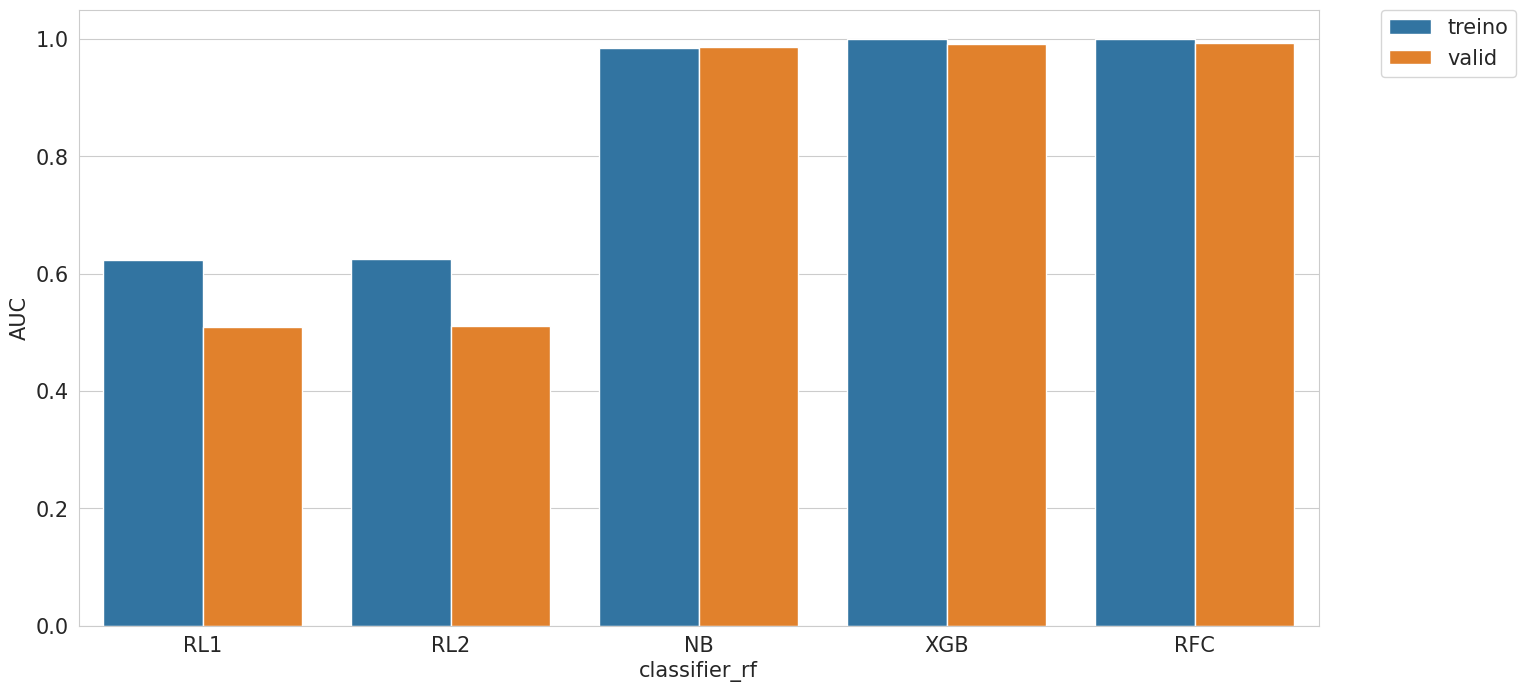

In [17]:
# Construção do Plot
sns.set_style("whitegrid")
plt.figure(figsize = (16, 8))

# Gráfico de barras
ax = sns.barplot(x = 'classifier', y = 'auc', hue = 'data_set', data = df_results)
ax.set_xlabel('classifier_rf', fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize = 15)

# Legenda
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)

## Hyperparameters and Cross-Validation

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [18]:
%%time

# Set hyperparameter
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# RandomForest
classifier_rf = RandomForestClassifier()

# GridSearchCV
grid_search = GridSearchCV(estimator = classifier_rf,
                           param_grid = param_grid,
                           cv = 5,
                           scoring = 'roc_auc',
                           verbose = 2,
                           n_jobs = -1)

# Train with best hyperparam
model_v5_opt = grid_search.fit(X_train_tf, y_train)

print('Best Hyperparam:', model_v5_opt.best_params_)

# Forecast
y_train_preds = model_v5_opt.predict_proba(X_train_tf)[:,1]
y_valid_preds = model_v5_opt.predict_proba(X_valid_tf)[:,1]

print('Random Forest Classifier with Optimization Hyperparameters and Cross-Validation:\n')

print('Train:\n')
rfc_train_auc, rfc_train_accuracy, rfc_train_recall, rfc_train_precision, rfc_train_specificity = print_report(y_train,
                                                                                                                   y_train_preds,
                                                                                                                   thresh)

print('Valid:\n')
rfc_valid_auc, rfc_valid_accuracy, rfc_valid_recall, rfc_valid_precision, rfc_valid_specificity = print_report(y_valid,
                                                                                                                   y_valid_preds,
                                                                                                                   thresh)


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparam: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Random Forest Classifier with Optimization Hyperparameters and Cross-Validation:

Train:

AUC:1.000
Accuracy:1.000
Recall:0.999
Precision:1.000
Specificity:1.000
 
Valid:

AUC:0.994
Accuracy:0.958
Recall:0.983
Precision:0.836
Specificity:0.952
 
CPU times: user 13 s, sys: 679 ms, total: 13.7 s
Wall time: 9min 42s


### Saving the best model

In [23]:
pickle.dump(modelo_v5, open('/content/melhor_modelo.pkl', 'wb'), protocol = 4)

In [26]:
# Load model, columns and scaler
best_model = pickle.load(open('/content/melhor_modelo.pkl','rb'))
cols_input = pickle.load(open('/content/colunas_entrada.sav','rb'))
scaler = pickle.load(open('/content/scaler.sav', 'rb'))

# load data
df_train = pd.read_csv('/content/dados_treino_final.csv')
df_valid = pd.read_csv('/content/dados_valid.csv')
df_test = pd.read_csv('/content/dados_teste.csv')

# Matrix X and Y

# X
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

# Y
y_train = df_train['LABEL_TARGET'].values
y_valid = df_valid['LABEL_TARGET'].values
y_test = df_test['LABEL_TARGET'].values

# Scaler
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

In [27]:
# Predict
y_train_preds = best_model.predict_proba(X_train_tf)[:,1]
y_valid_preds = best_model.predict_proba(X_valid_tf)[:,1]
y_test_preds = best_model.predict_proba(X_test_tf)[:,1]

In [28]:
thresh = 0.5

print('\nTrain:\n')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = print_report(y_train,
                                                                                               y_train_preds,
                                                                                               thresh)

print('\nValid:\n')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = print_report(y_valid,
                                                                                               y_valid_preds,
                                                                                               thresh)

print('\nTest:\n')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = print_report(y_test,
                                                                                          y_test_preds,
                                                                                          thresh)


Train:

AUC:1.000
Accuracy:1.000
Recall:1.000
Precision:1.000
Specificity:1.000
 

Valid:

AUC:0.994
Accuracy:0.958
Recall:0.974
Precision:0.841
Specificity:0.952
 

Test:

AUC:0.994
Accuracy:0.958
Recall:0.979
Precision:0.834
Specificity:0.948
 


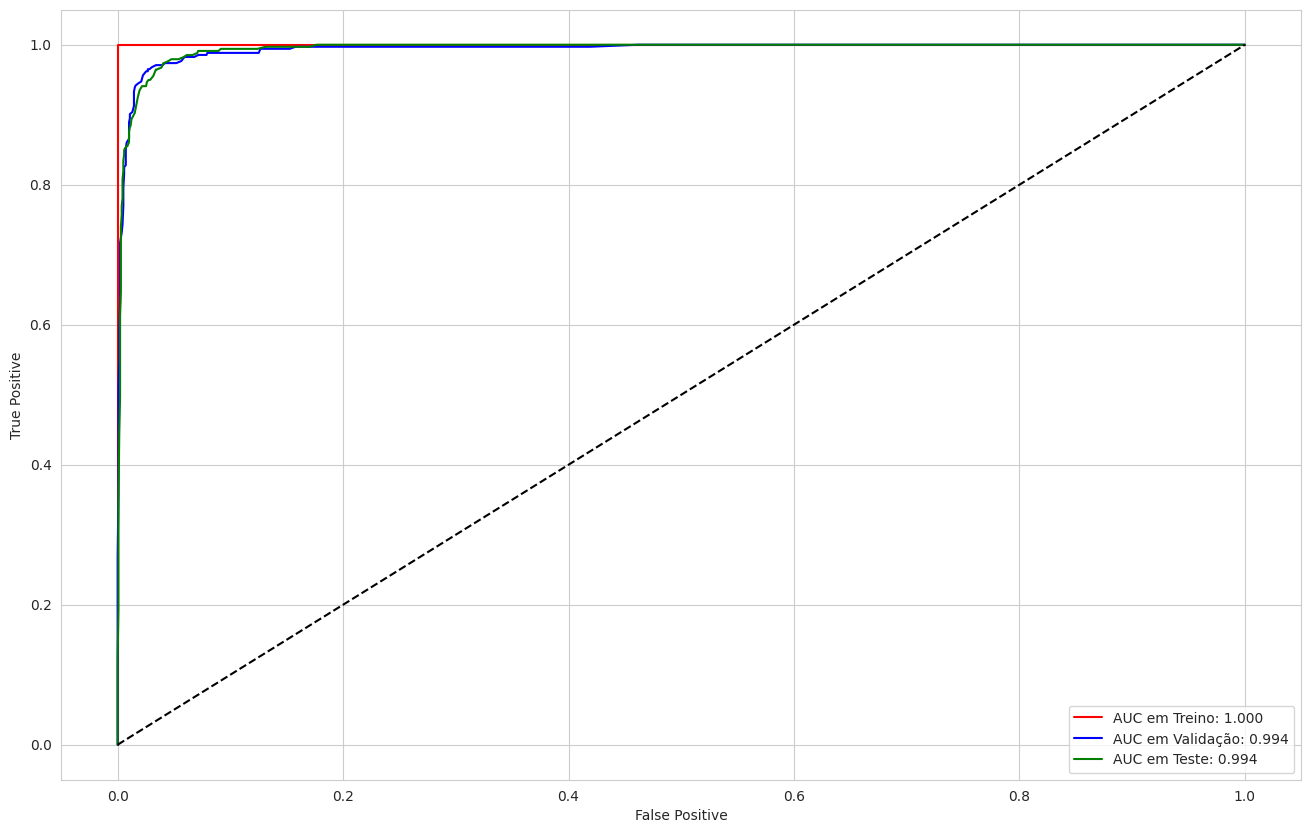

In [36]:
# ROC Train
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

# ROC Valid
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

# ROC Test
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

# Plot
plt.figure(figsize=(16,10))
plt.plot(fpr_train, tpr_train, 'r-', label = 'AUC em Treino: %.3f'%auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label = 'AUC em Validação: %.3f'%auc_valid)
plt.plot(fpr_test, tpr_test, 'g-', label = 'AUC em Teste: %.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()
plt.show()

## Deploy

In [39]:
# Load new client
new_client = pd.read_csv('/content/novo_cliente.csv')

In [40]:
new_client.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,42,53,44,31,15,12,6,4,1,-4,...,-41,-16,2,22,33,45,56,67,69,63


In [41]:
new_client_scaled = scaler.transform(novo_cliente)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [42]:
new_client_scaled

array([[ 0.23430103,  0.26330964,  0.21327887,  0.14547427,  0.06433421,
         0.04162138,  0.01245067,  0.00948678,  0.0004072 , -0.02089583,
        -0.05982225, -0.08823802, -0.09422636, -0.08206851, -0.05688321,
        -0.04513061, -0.04888646, -0.05884649, -0.03954335, -0.0268048 ,
        -0.03954517, -0.01361066,  0.0141796 ,  0.02964142,  0.02434803,
         0.02553403,  0.05046526,  0.07622867,  0.10625282,  0.10435503,
         0.08770101,  0.03628219,  0.02035452,  0.00290372,  0.02560331,
         0.04788545,  0.0803539 ,  0.11439743,  0.1269662 ,  0.15967329,
         0.17008419,  0.18494295,  0.17441442,  0.19293274,  0.19279889,
         0.18807764,  0.17420266,  0.13057865,  0.07347198,  0.02760618,
         0.01334455, -0.04209115, -0.09817825, -0.14470692, -0.17500193,
        -0.19419077, -0.19392033, -0.18826305, -0.17409285, -0.13599362,
        -0.09777884, -0.06104059, -0.02889629, -0.05156025, -0.04717145,
        -0.04596022, -0.03446032,  0.01195965,  0.0

In [43]:
best_model.predict_proba(new_client_scaled)

array([[1., 0.]])

In [44]:
best_model.predict(novo_cliente_scaled)

array([0])

Model's prediction, this customer will not renew the insurance.